# штуки чтоб юзался гпу

In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.10.1
Num GPUs Available:  1


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU используется")
    except RuntimeError as e:
        print(e)
else:
    print("GPU не найден, используется CPU")


GPU используется


In [3]:
from pathlib import Path
import pandas as pd

base = Path("BBC News Summary")

categories = ["business", "entertainment", "politics", "sport", "tech"]


def load_split(kind):
    rows = []
    for cat in categories:
        folder = base / kind / cat
        for file in folder.glob("*.txt"):
            try:
                text = file.read_text(encoding="utf8")
            except UnicodeDecodeError:
                try:
                    text = file.read_text(encoding="latin1")
                except:
                    text = file.read_text(encoding="utf8", errors="replace")

            rows.append([text, cat])
    return pd.DataFrame(rows, columns=["text", "category"])


articles = load_split("News Articles")
summaries = load_split("Summaries")

In [4]:
print("статьи")
print(articles.groupby("category").size(), "\n")

print("саммари")
print(summaries.groupby("category").size())


статьи
category
business         510
entertainment    386
politics         417
sport            511
tech             401
dtype: int64 

саммари
category
business         510
entertainment    386
politics         417
sport            511
tech             401
dtype: int64


# чистка

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemm = WordNetLemmatizer()


def clean_text(text):
    text = text.lower()
    text = text.replace("\n", " ")
    text = re.sub(r"[^a-z\s]", " ", text)
    tokenized = nltk.word_tokenize(text)
    tokenized = [w for w in tokenized if w not in stop_words and len(w) > 3]
    tokenized = [lemm.lemmatize(w) for w in tokenized]
    return " ".join(tokenized)


In [6]:
articles["clean_text"] = articles["text"].apply(clean_text)
summaries["clean_text"] = summaries["text"].apply(clean_text)

In [7]:
articles.head()

,text,category,clean_text
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,sale boost time warner profit quarterly profit...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,dollar gain greenspan speech dollar highest le...
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,yukos unit buyer face loan claim owner embattl...
3,High fuel prices hit BA's profits\n\nBritish A...,business,high fuel price profit british airway blamed h...
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,pernod takeover talk lift domecq share drink f...


In [8]:
summaries.head

<bound method NDFrame.head of                                                    text  category  \
0     TimeWarner said fourth quarter sales rose 2% t...  business   
1     The dollar has hit its highest level against t...  business   
2     Yukos' owner Menatep Group says it will ask Ro...  business   
3     Rod Eddington, BA's chief executive, said the ...  business   
4     Pernod has reduced the debt it took on to fund...  business   
...                                                 ...       ...   
2220  BT is introducing two initiatives to help beat...      tech   
2221  A third of them read unsolicited junk e-mail a...      tech   
2222  This goes to the heart of the European project...      tech   
2223  Amit Yoran was director of the National Cyber ...      tech   
2224  He says that in the world of online gaming suc...      tech   

                                             clean_text  
0     timewarner said fourth quarter sale rose full ...  
1     dollar highest leve

# A: Классическая модель

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_articles = articles["clean_text"].values
y_articles = articles["category"].values

X_summaries = summaries["clean_text"].values
y_summaries = summaries["category"].values

# кодируем метки
le = LabelEncoder()
y_articles_enc = le.fit_transform(y_articles)
y_summaries_enc = le.transform(y_summaries)

X_train_art, X_test_art, y_train_art, y_test_art = train_test_split(
    X_articles, y_articles_enc, test_size=0.2, random_state=42, stratify=y_articles_enc
)

X_train_sum, X_test_sum, y_train_sum, y_test_sum = train_test_split(
    X_summaries, y_summaries_enc, test_size=0.2, random_state=42, stratify=y_summaries_enc
)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_art = TfidfVectorizer(max_features=10000)
X_train_art_tfidf = tfidf_art.fit_transform(X_train_art)
X_test_art_tfidf = tfidf_art.transform(X_test_art)

tfidf_sum = TfidfVectorizer(max_features=10000)
X_train_sum_tfidf = tfidf_sum.fit_transform(X_train_sum)
X_test_sum_tfidf = tfidf_sum.transform(X_test_sum)


In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

le = LabelEncoder()
y_articles_enc = le.fit_transform(y_articles)
y_summaries_enc = le.transform(y_summaries)

rf = RandomForestClassifier(n_estimators=200, random_state=42)

rf.fit(X_train_art_tfidf, y_train_art)
y_pred_art_rf = rf.predict(X_test_art_tfidf)
acc_art_rf = accuracy_score(y_test_art, y_pred_art_rf)
precision_art_rf, recall_art_rf, f1_art_rf, _ = precision_recall_fscore_support(
    y_test_art, y_pred_art_rf, average="weighted"
)

rf.fit(X_train_sum_tfidf, y_train_sum)
y_pred_sum_rf = rf.predict(X_test_sum_tfidf)
acc_sum_rf = accuracy_score(y_test_sum, y_pred_sum_rf)
precision_sum_rf, recall_sum_rf, f1_sum_rf, _ = precision_recall_fscore_support(
    y_test_sum, y_pred_sum_rf, average="weighted"
)


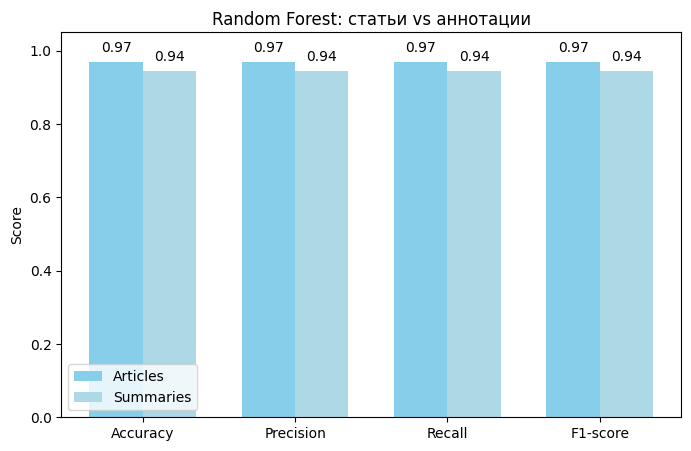

In [12]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Accuracy", "Precision", "Recall", "F1-score"]
metrics_art_rf = [acc_art_rf, precision_art_rf, recall_art_rf, f1_art_rf]
metrics_sum_rf = [acc_sum_rf, precision_sum_rf, recall_sum_rf, f1_sum_rf]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width / 2, metrics_art_rf, width, label='Articles', color='skyblue')
ax.bar(x + width / 2, metrics_sum_rf, width, label='Summaries', color='lightblue')

ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("Random Forest: статьи vs аннотации")
ax.legend()

for i, (a, s) in enumerate(zip(metrics_art_rf, metrics_sum_rf)):
    ax.text(i - width / 2, a + 0.02, f"{a:.2f}", ha='center', va='bottom')
    ax.text(i + width / 2, s + 0.02, f"{s:.2f}", ha='center', va='bottom')

plt.show()


In [13]:
import numpy as np

art_lengths = np.array([len(text.split()) for text in X_train_art])
sum_lengths = np.array([len(text.split()) for text in X_train_sum])

percentiles = [50, 75, 90, 95, 99]

print("Статьи:")
for p in percentiles:
    print(f"{p}-й перцентиль: {np.percentile(art_lengths, p):.0f} слов")

print("\nАннотации:")
for p in percentiles:
    print(f"{p}-й перцентиль: {np.percentile(sum_lengths, p):.0f} слов")


Статьи:
50-й перцентиль: 170 слов
75-й перцентиль: 242 слов
90-й перцентиль: 315 слов
95-й перцентиль: 367 слов
99-й перцентиль: 471 слов

Аннотации:
50-й перцентиль: 76 слов
75-й перцентиль: 109 слов
90-й перцентиль: 143 слов
95-й перцентиль: 167 слов
99-й перцентиль: 215 слов


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_words_art = 15000
max_len_art = 600
max_words_sum = 10000
max_len_sum = 200

tokenizer_art = Tokenizer(num_words=max_words_art)
tokenizer_art.fit_on_texts(X_train_art)
X_train_art_seq = pad_sequences(tokenizer_art.texts_to_sequences(X_train_art), maxlen=max_len_art)
X_test_art_seq = pad_sequences(tokenizer_art.texts_to_sequences(X_test_art), maxlen=max_len_art)
y_train_art_cat = to_categorical(y_train_art)
y_test_art_cat = to_categorical(y_test_art)

tokenizer_sum = Tokenizer(num_words=max_words_sum)
tokenizer_sum.fit_on_texts(X_train_sum)
X_train_sum_seq = pad_sequences(tokenizer_sum.texts_to_sequences(X_train_sum), maxlen=max_len_sum)
X_test_sum_seq = pad_sequences(tokenizer_sum.texts_to_sequences(X_test_sum), maxlen=max_len_sum)
y_train_sum_cat = to_categorical(y_train_sum)
y_test_sum_cat = to_categorical(y_test_sum)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


def build_lstm_model(input_length, max_words, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=input_length))
    model.add(LSTM(128, dropout=0.0, recurrent_dropout=0.0))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model_art = build_lstm_model(max_len_art, max_words_art, len(categories))
model_sum = build_lstm_model(max_len_sum, max_words_sum, len(categories))


In [21]:
history_art = model_art.fit(
    X_train_art_seq, y_train_art_cat,
    validation_split=0.1,
    epochs=5,
    batch_size=32
)

history_sum = model_sum.fit(
    X_train_sum_seq, y_train_sum_cat,
    validation_split=0.1,
    epochs=5,
    batch_size=32
)


Epoch 1/5
51/51 [==============================] - 4s 51ms/step - loss: 1.5222 - accuracy: 0.3964 - val_loss: 1.3511 - val_accuracy: 0.4494
Epoch 2/5
51/51 [==============================] - 2s 48ms/step - loss: 0.7374 - accuracy: 0.7553 - val_loss: 0.5731 - val_accuracy: 0.8315
Epoch 3/5
51/51 [==============================] - 3s 49ms/step - loss: 0.3334 - accuracy: 0.9101 - val_loss: 0.3607 - val_accuracy: 0.9213
Epoch 4/5
51/51 [==============================] - 2s 49ms/step - loss: 0.0690 - accuracy: 0.9888 - val_loss: 0.3034 - val_accuracy: 0.9045
Epoch 5/5
51/51 [==============================] - 2s 45ms/step - loss: 0.0255 - accuracy: 0.9981 - val_loss: 0.1846 - val_accuracy: 0.9663
Epoch 1/5
51/51 [==============================] - 2s 24ms/step - loss: 1.5207 - accuracy: 0.4139 - val_loss: 1.1638 - val_accuracy: 0.4494
Epoch 2/5
51/51 [==============================] - 1s 19ms/step - loss: 0.8933 - accuracy: 0.6729 - val_loss: 0.9256 - val_accuracy: 0.6798
Epoch 3/5
51/51 [===

## метрики rnn

14/14 [==============================] - 0s 8ms/step


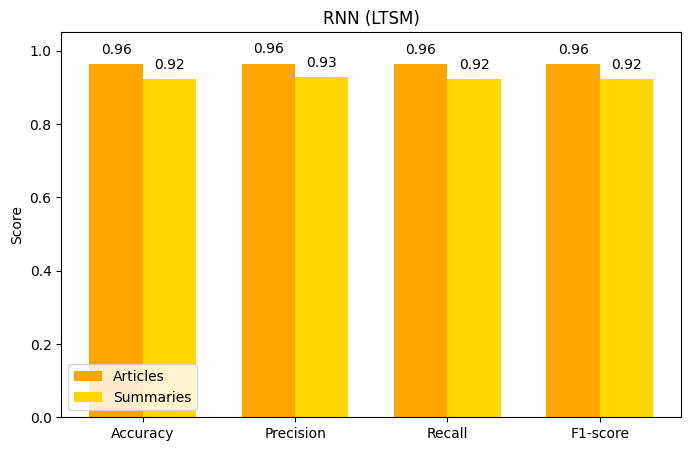

In [22]:
y_pred_art_rnn = model_art.predict(X_test_art_seq)
y_pred_art_rnn_labels = y_pred_art_rnn.argmax(axis=1)
acc_art_rnn = accuracy_score(y_test_art, y_pred_art_rnn_labels)
precision_art_rnn, recall_art_rnn, f1_art_rnn, _ = precision_recall_fscore_support(
    y_test_art, y_pred_art_rnn_labels, average="weighted"
)

y_pred_sum_rnn = model_sum.predict(X_test_sum_seq)
y_pred_sum_rnn_labels = y_pred_sum_rnn.argmax(axis=1)
acc_sum_rnn = accuracy_score(y_test_sum, y_pred_sum_rnn_labels)
precision_sum_rnn, recall_sum_rnn, f1_sum_rnn, _ = precision_recall_fscore_support(
    y_test_sum, y_pred_sum_rnn_labels, average="weighted"
)

metrics_art_rnn = [acc_art_rnn, precision_art_rnn, recall_art_rnn, f1_art_rnn]
metrics_sum_rnn = [acc_sum_rnn, precision_sum_rnn, recall_sum_rnn, f1_sum_rnn]

width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width / 2, metrics_art_rnn, width, label='Articles', color='orange')
ax.bar(x + width / 2, metrics_sum_rnn, width, label='Summaries', color='gold')

ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("RNN (LTSM)")
ax.legend()

for i, (a, s) in enumerate(zip(metrics_art_rnn, metrics_sum_rnn)):
    ax.text(i - width / 2, a + 0.02, f"{a:.2f}", ha='center', va='bottom')
    ax.text(i + width / 2, s + 0.02, f"{s:.2f}", ha='center', va='bottom')

plt.show()


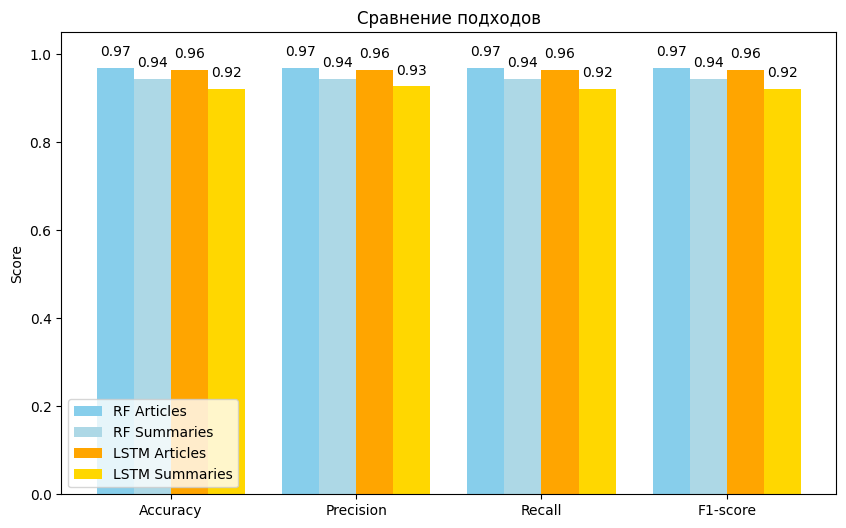

In [23]:
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 1.5 * width, metrics_art_rf, width, label='RF Articles', color='skyblue')
ax.bar(x - 0.5 * width, metrics_sum_rf, width, label='RF Summaries', color='lightblue')
ax.bar(x + 0.5 * width, metrics_art_rnn, width, label='LSTM Articles', color='orange')
ax.bar(x + 1.5 * width, metrics_sum_rnn, width, label='LSTM Summaries', color='gold')

ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("Сравнение подходов")
ax.legend()

for i in range(len(labels)):
    for offset, metric in zip([-1.5 * width, -0.5 * width, 0.5 * width, 1.5 * width],
                              [metrics_art_rf[i], metrics_sum_rf[i], metrics_art_rnn[i], metrics_sum_rnn[i]]):
        ax.text(i + offset, metric + 0.02, f"{metric:.2f}", ha='center', va='bottom')

plt.show()
